## Rating each node

The purpose is to select one left-behind node and move it out for system refreshment.
Proposed modeling is as following:
1. Collect node feature: cpu, memory, disk and netowrk usage, as feature
2. Training the data to partition all the observed data into two catalogs
3. If there find a majority, > 90%, label it as 1 and label the minority as 0
4. For each node, score is caculated as expected value of all observed data on this node.
5. The "most different" node is selected if it has lowest score.
Assuming most of the nodes is in good shape, the model should be able to pick out "abnormal" node.

Following command would collect node system information every 30s for 24 hours
> nmon -f -s30 -c2880

Parse the nmon file to csv
> pyNmonAnalyzer -c -o output -i input.nmon

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
def sigmoid(z):
    s = 100.0 / (1.0 + np.exp(-1.0 * z))
    return s
from scipy.stats import zscore
def maxr(z):
    maxv = z.max()
    return z*100/maxv

norm_func = maxr
    

In [4]:
data_dir = "data/2017-06-22"
nodes = """enn-yc-13  enn-yc-16  enn-yc-19  enn-yc-22  enn-yc-25  enn-yc-28  enn-yc-31  enn-yc-34 
enn-yc-37  enn-yc-40  enn-yc-43  enn-yc-46  enn-yc-14  enn-yc-17  enn-yc-20  enn-yc-23  
enn-yc-26  enn-yc-29  enn-yc-32  enn-yc-35  enn-yc-38  enn-yc-41  enn-yc-44  enn-yc-47
enn-yc-15  enn-yc-18  enn-yc-21  enn-yc-24  enn-yc-27  enn-yc-30  enn-yc-33  enn-yc-36
enn-yc-39  enn-yc-42  enn-yc-45"""
import re
nodes = sorted(re.split("\s+", nodes))

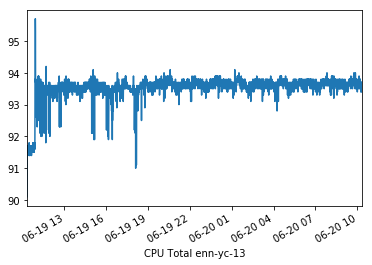

In [6]:
import os
cpu = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "CPU_ALL.csv"), parse_dates=[0], index_col=0)
# cpu
cpu["Idle%"].plot()
#disk = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "DISKBUSY.csv"), parse_dates=[0], index_col=0)
#norm_func(disk.sum(axis=1)).plot()
#memory = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "MEM.csv"), parse_dates=[0], index_col=0)
#norm_func(memory['memfree']).plot();plt.show()
#norm_func(memory['cached']).plot();plt.show()
#norm_func(memory['active']).plot();plt.show()
#net = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "NET.csv"), parse_dates=[0], index_col=0)
#reads = net[[n for n in net.columns if "read" in n]].sum(axis=1)
#writes = net[[n for n in net.columns if "write" in n]].sum(axis=1)
#norm_func(reads).plot();plt.show()
#norm_func(writes).plot()
#package = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "NETPACKET.csv"), parse_dates=[0], index_col=0)
#reads = package[[n for n in package.columns if "read" in n]].sum(axis=1)
#writes = package[[n for n in package.columns if "write" in n]].sum(axis=1)
#norm_func(reads).plot();plt.show()
#norm_func(writes).plot()
#proc = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "PROC.csv"), parse_dates=[0], index_col=0)
#norm_func(proc['Runnable']).plot()
#norm_func(proc['Blocked']).plot()
#norm_func(proc['pswitch']).plot()
#norm_func(proc['fork']).plot()
#vm = pd.read_csv(os.path.join(data_dir, nodes[0], "csv", "VM.csv"), parse_dates=[0], index_col=0)
#norm_func(vm['nr_dirty']).plot();plt.show()
#norm_func(vm['nr_writeback']).plot();plt.show()
#norm_func(vm['nr_page_table_pages']).plot();plt.show()
#norm_func(vm['nr_mapped']).plot();plt.show()
#norm_func(vm['pgpgin']).plot();plt.show()
#norm_func(vm['pgpgout']).plot();plt.show()
#norm_func(vm['pgfree']).plot();plt.show()
#norm_func(vm['pgactivate']).plot();plt.show()
#norm_func(vm['pgfault']).plot();plt.show()
#norm_func(vm['pgalloc_normal']).plot();plt.show()

In [7]:
def collect(node, idx):
    files = ["CPU_ALL.csv", "DISKBUSY.csv", "MEM.csv", "NET.csv", "NETPACKET.csv", "PROC.csv", "VM.csv"]
    cpu, disk, memory, net, package, proc, vm = [
        pd.read_csv(os.path.join(data_dir, node, "csv", f), parse_dates=[0], index_col=0) for f in files
    ]    
    r = pd.concat([
        cpu["Idle%"],
        norm_func(disk.sum(axis=1)),
        norm_func(memory['memfree']),
        norm_func(memory['cached']),
        norm_func(memory['active']),
        norm_func(net[[n for n in net.columns if "read" in n]].sum(axis=1)),
        norm_func(net[[n for n in net.columns if "write" in n]].sum(axis=1)),
        norm_func(package[[n for n in package.columns if "read" in n]].sum(axis=1)),
        norm_func(package[[n for n in package.columns if "write" in n]].sum(axis=1)),
        norm_func(proc['Runnable']),
        norm_func(proc['Blocked']),
        norm_func(proc['pswitch']),
        norm_func(proc['fork']),
        norm_func(vm['nr_dirty']),
        norm_func(vm['nr_writeback']),
        norm_func(vm['nr_page_table_pages']),
        norm_func(vm['nr_mapped']),
        norm_func(vm['pgpgin']),
        norm_func(vm['pgpgout']),
        norm_func(vm['pgfree']),
        norm_func(vm['pgactivate']),
        norm_func(vm['pgfault']),
        norm_func(vm['pgalloc_normal'])            
        ], axis=1
    )
    r['node'] = idx
    return r
dataset = np.concatenate([collect(n, i+13) for i,n in enumerate(nodes)])

In [9]:
print dataset.shape
X = dataset[:, :-1]
Y = dataset[:, -1]

(100744, 24)


In [159]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

NameError: name 'n_clusters' is not defined

In [160]:
print n_clusters_

24


In [198]:
# node_names = np.map(Y, lambda x: nodes[x-13])

In [13]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
tX = pca.transform(X)
#plt.figure(figsize=(12, 8))
#plt.scatter(tX[:, 0], tX[:, 1], c=Y, alpha=0.6)
#plt.colorbar()

<IPython.core.display.Javascript object>


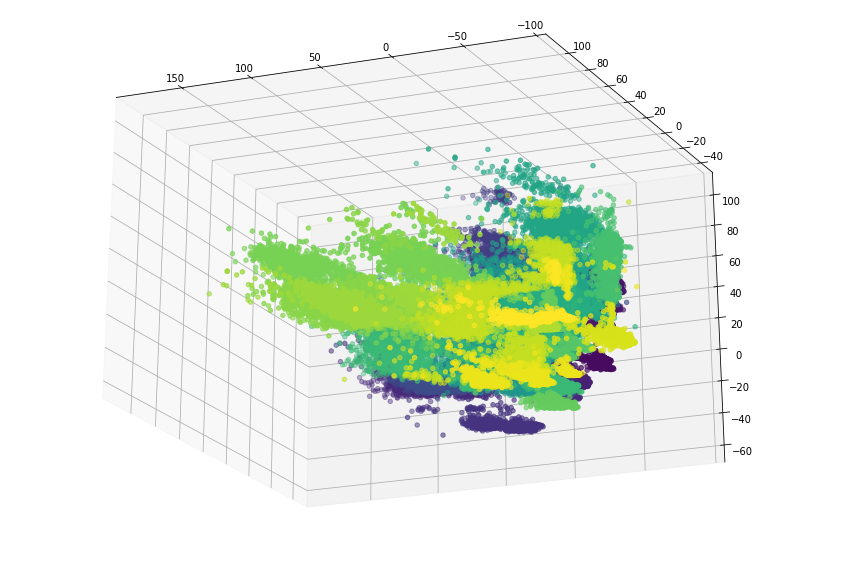

In [16]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(tX[:, 0], tX[:, 1], tX[:, 2], c=Y)
plt.show()

In [17]:
from sklearn.cluster import KMeans

random_state = 0
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(tX)

In [18]:
result = pd.DataFrame({"cluster": y_pred, "node": Y})

In [19]:
# result[result['cluster']==2].groupby(["node"]).size().reset_index().head(100)
result.groupby(['node', 'cluster']).size().unstack().fillna(0)

cluster,0,1,2
node,,,
13.0,1085.0,1794.0,1.0
14.0,499.0,2381.0,0.0
15.0,122.0,2758.0,0.0
16.0,105.0,2775.0,0.0
17.0,1299.0,1568.0,13.0
18.0,2875.0,5.0,0.0
19.0,2822.0,1.0,1.0
20.0,370.0,2510.0,0.0
21.0,1263.0,1570.0,47.0
